### MCMC w/ bimodal likelihood

$\mu_1 = [3,3]$, $\mu_2 = [-3,-3]$, $\Sigma = I = \begin{bmatrix} 1 & 0 \\ 0 & 1   \end{bmatrix}$  
Basic VLM: "the distribution is unambiguously bimodal"  
Plot judge: "the plot visually represents a bimodal distribution"  
cmbagent: "distribution appears bimodal"

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:09<00:00, 1073.20it/s]


Saved 1000000 samples to MCMC/ directory


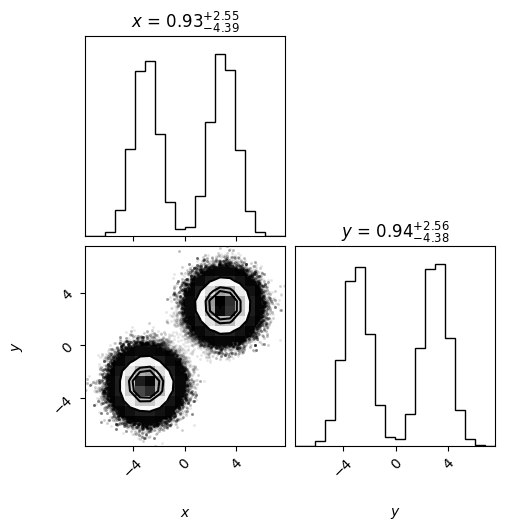

In [9]:
import numpy as np
import emcee
import json
import os
import corner
import matplotlib.pyplot as plt
import cmbagent

# Uniform prior over the square [-10,10]^2
def log_prior(theta):
    x, y = theta
    if -10 < x < 10 and -10 < y < 10:
        return 0.0  # log(1)
    return -np.inf

# Mixture of two Gaussians
def log_likelihood(theta):
    x, y = theta
    mu1 = np.array([-3, -3])
    mu2 = np.array([+3, +3])
    cov_inv = np.eye(2)  # No correlation

    def log_gauss(mu):
        d = np.array([x, y]) - mu
        return -0.5 * np.dot(d, cov_inv.dot(d))

    # log-sum-exp for two equal-weight components
    l1 = log_gauss(mu1)
    l2 = log_gauss(mu2)
    
    # Factor out the normalization
    return np.logaddexp(l1, l2) - np.log(2.0)

# Combine prior and likelihood
def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

ndim = 2
nwalkers = 100

# Initialize walkers in a small Gaussian ball around the origin
p0 = np.random.randn(nwalkers, ndim) * 1.0
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

nburn = 500
sampler.run_mcmc(p0, nburn, progress=True)
sampler.reset()  # Discard burn‐in samples
nsteps = 10000
sampler.run_mcmc(None, nsteps, progress=True)

# Flatten the chain to shape (nwalkers * nsteps, ndim)
samples = sampler.get_chain(flat=True)

# Save the chains and samples for later analysis
os.makedirs("/Users/kahaan/Downloads/cmbagent/MCMC", exist_ok=True)
np.save("/Users/kahaan/Downloads/cmbagent/MCMC/samples.npy", samples)
np.save("/Users/kahaan/Downloads/cmbagent/MCMC/chain.npy", sampler.get_chain())
np.save("/Users/kahaan/Downloads/cmbagent/MCMC/log_prob.npy", sampler.get_log_prob())

# Also save metadata
metadata = {
    'nwalkers': nwalkers,
    'nsteps': nsteps,
    'nburn': nburn,
    'ndim': ndim,
    'total_samples': len(samples)
}

with open("/Users/kahaan/Downloads/cmbagent/MCMC/metadata.json", 'w') as f:
    json.dump(metadata, f)

print(f"Saved {len(samples)} samples to MCMC/ directory")

# Generate and save the corner plot
figure = corner.corner(
    samples,
    labels=["$x$", "$y$"],
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
)
corner_plot_path = "/Users/kahaan/Downloads/cmbagent/MCMC/bimodal_corner_plot.png"
figure.savefig(corner_plot_path, dpi=150)
plt.show()

In [2]:
import base64
import json
from PIL import Image
from google import genai
from cmbagent.utils import get_api_keys_from_env
from autogen.agentchat.group import ContextVariables

api_keys = get_api_keys_from_env()
client = genai.Client(api_key=api_keys["GEMINI"])

def load_plot_as_base64(image_path):
    """Load an image and convert to base64 for VLM analysis"""
    with open(image_path, 'rb') as f:
        image_data = f.read()
        return base64.b64encode(image_data).decode('utf-8')

# Get corner plot path
corner_plot_path = "/Users/kahaan/Downloads/cmbagent/MCMC/bimodal_corner_plot.png"
plot_base64 = load_plot_as_base64(corner_plot_path)

In [6]:
# APPROACH 1: default API call

question = "This is a corner plot of an MCMC posterior. What can you tell me about the shape of the distribution and whether it looks bimodal?"

answer = client.models.generate_content(
    model="gemini-2.5-pro",
    contents=[
        {
            'role': 'user',
            'parts': [
                {'inline_data': {'mime_type': 'image/png', 'data': plot_base64}},
                {'text': question}
            ]
        }
    ]
)

print(answer.text)

Of course! This is an excellent example of a corner plot showing a multimodal posterior distribution. Here's a detailed breakdown of what the plots reveal.

### Overall Conclusion

Yes, the distribution is unambiguously **bimodal**. This is evident in all three panels of the corner plot.

### Detailed Analysis

Let's break down what each part of the plot tells us:

#### 1. The 1D Marginalized Distributions (Histograms)

These are the plots on the diagonal of the corner plot. They show the probability distribution for each parameter individually, after "integrating out" the other parameter.

*   **Top Plot (Distribution for `x`):**
    *   This histogram clearly shows two distinct, well-separated peaks. One peak is centered around **x ≈ -3** and the other is centered around **x ≈ +3**.
    *   This indicates that the parameter `x` is bimodal. There are two "islands" of high probability for `x`, with a region of very low probability in between (around x=0).
    *   The title `x = -1.19 +

In [7]:
# APPROACH 2: vision-based analysis with plot judge

from cmbagent.vlm_utils import send_image_to_vlm, create_vlm_prompt

# Create context variables for the VLM system
context_variables = ContextVariables()
context_variables["improved_main_task"] = "Evaluate whether the given corner plot is bimodal."

# Plot judge relies on function, not AG2 agent
completion, injected_code = send_image_to_vlm(
    base_64_img=plot_base64,
    vlm_prompt=create_vlm_prompt(context_variables),
    inject_wrong_plot=False,
    context_variables=context_variables
)

# Parse the structured response
analysis = json.loads(completion.choices[0].message.content)
print(analysis)

VLM scientific accuracy description:
Assessment of scientific accuracy: Are the data points, calculations, and scientific principles accurate? Are the units, scales, and relationships correct? Are there any mathematical or scientific errors?

ADDITIONAL DOMAIN-SPECIFIC CRITERIA:
Bimodal Distribution Indicator: Expected presence of two distinct peaks

1. Peak Locations:
   - x-axis: Distinct peaks should have local maxima at separate x-values.
   - If peaks merge into one: indicates lack of bimodality, possibly due to insufficient resolution or data smoothing (invalid as the goal is to assess bimodality).
   - If multiple additional peaks appear: suggests noise or overfitting (invalid without physical justification for multiple processes).

2. Relative Height and Width:
   - y-axis: Peaks should have distinguishable heights, indicating different modes in the data.
   - Mismatched peak heights: suggests sampling bias or an artifact (invalid as true bimodal distributions typically have pe

In [10]:
# APPROACH 3: text-based analysis with cmbagent

# Save a simple data description file for cmbagent to find
data_info_content = f"""
# MCMC Posterior Samples Data

This directory contains MCMC posterior samples from a bimodal distribution analysis.

Files:
- samples.npy: Flattened MCMC samples (shape: {len(np.load('/Users/kahaan/Downloads/cmbagent/MCMC/samples.npy'))}, 2)
- chain.npy: Full MCMC chain data  
- log_prob.npy: Log probability values
- metadata.json: Run parameters and statistics

Task: Analyze this data to determine the shape of the distribution and assess bimodality.
"""

# Save data info file
with open("/Users/kahaan/Downloads/cmbagent/MCMC/README.md", 'w') as f:
    f.write(data_info_content)

# Create task for cmbagent - give it the data path and let it analyze
task = f"""
You have been provided with MCMC posterior sample data in the directory /Users/kahaan/Downloads/cmbagent/MCMC/

Load and analyze the samples.npy file (and other data files as needed) to determine the shape of the distribution and whether it looks bimodal.

Give a clear conclusion based on the data.
"""
import cmbagent
import tempfile

with tempfile.TemporaryDirectory() as temp_work_dir:    
    results = cmbagent.one_shot(
        task=task,
        max_rounds=10,
        agent='engineer',
        work_dir=temp_work_dir,
        evaluate_plots=False,
    )


You have been provided with MCMC posterior sample data in the directory /Users/kahaan/Downloads/cmbagent/MCMC/

Load and analyze the samples.npy file (and other data files as needed) to determine the shape of the distribution and whether it looks bimodal.

Give a clear conclusion based on the data.


--------------------------------------------------------------------------------

Calling engineer...

             Model    agent    Cost  Prompt Tokens  Completion Tokens  Total Tokens
gpt-4.1-2025-04-14 engineer 0.01218           1704               1096          2800
**Code Explanation:**

This code loads the MCMC posterior samples from the provided `samples.npy` file, analyzes the shape of the distribution for each parameter, and checks for bimodality. It does this by:
- Loading the samples and printing their shape and basic statistics.
- Plotting the marginal distributions (histograms and kernel density estimates) for each parameter.
- Computing the Hartigan's Dip Test for unimodalit

### MCMC w/ parabolic likelihood

$$
\log p(\theta \mid \text{data}) =
\begin{cases}
-\dfrac{1}{2} \left[ x^2 + \left(y - \beta x^2 \right)^2 \right], & \text{if } -10 < x < 10 \text{ and } -10 < y < 10 \\
-\infty, & \text{otherwise}
\end{cases}
$$

Basic VLM: "the posterior distribution clearly exhibits banana-shaped curvature"  
Plot judge: "the plot accurately visualizes a non-linear correlation between the two parameters"  
cmbagent: "the distribution does not exhibit a strong correlation between the parameters" (falls below correlation threshold)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1776.85it/s]


Saved 1000000 samples to /Users/kahaan/Downloads/cmbagent/MCMC_banana_single/


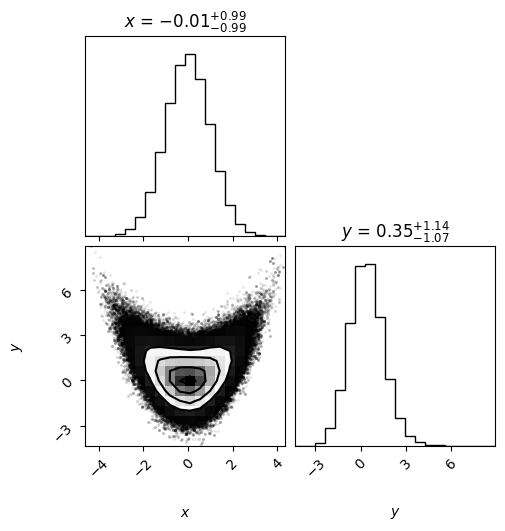

In [13]:
import numpy as np
import emcee
import json
import os
import corner
import matplotlib.pyplot as plt

# Uniform Prior over square [-10, 10]^2
def log_prior(theta):
    x, y = theta
    if -10 < x < 10 and -10 < y < 10:
        return 0.0  # log(1)
    return -np.inf

beta = 0.4  # Controls curvature

# Log-likelihood: banana-shaped Gaussian
def log_likelihood(theta):
    x, y = theta
    x0, y0 = 0.0, 0.0  # Center of the banana
    x_shift = x - x0
    y_shift = y - y0 - beta * x**2  # Warping
    d = np.array([x_shift, y_shift])
    cov_inv = np.eye(2)
    return -0.5 * np.dot(d, cov_inv.dot(d))

# Posterior = Prior x Likelihood
def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

# MCMC setup
ndim = 2
nwalkers = 100
p0 = np.random.randn(nwalkers, ndim) * 1.0
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

# Burn-in and sampling
nburn = 500
sampler.run_mcmc(p0, nburn, progress=True)
sampler.reset()
nsteps = 10000
sampler.run_mcmc(None, nsteps, progress=True)
samples = sampler.get_chain(flat=True)

# Save outputs
output_dir = "/Users/kahaan/Downloads/cmbagent/MCMC_banana"
os.makedirs(output_dir, exist_ok=True)
np.save(os.path.join(output_dir, "samples.npy"), samples)
np.save(os.path.join(output_dir, "chain.npy"), sampler.get_chain())
np.save(os.path.join(output_dir, "log_prob.npy"), sampler.get_log_prob())

metadata = {
    'nwalkers': nwalkers,
    'nsteps': nsteps,
    'nburn': nburn,
    'ndim': ndim,
    'beta': beta,
    'total_samples': len(samples)
}
with open(os.path.join(output_dir, "metadata.json"), 'w') as f:
    json.dump(metadata, f)

print(f"Saved {len(samples)} samples to {output_dir}/")

# Corner plot
figure = corner.corner(
    samples,
    labels=["$x$", "$y$"],
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
)
corner_plot_path = os.path.join(output_dir, "banana_corner_plot.png")
figure.savefig(corner_plot_path, dpi=150)
plt.show()

In [15]:
import base64
import json
from PIL import Image
from google import genai
from cmbagent.utils import get_api_keys_from_env
from autogen.agentchat.group import ContextVariables

api_keys = get_api_keys_from_env()
client = genai.Client(api_key=api_keys["GEMINI"])

def load_plot_as_base64(image_path):
    """Load an image and convert to base64 for VLM analysis"""
    with open(image_path, 'rb') as f:
        image_data = f.read()
        return base64.b64encode(image_data).decode('utf-8')

# Get corner plot path
corner_plot_path = "/Users/kahaan/Downloads/cmbagent/MCMC_banana/banana_corner_plot.png"
plot_base64 = load_plot_as_base64(corner_plot_path)

In [16]:
# APPROACH 1: default API call

question = "This is a corner plot of an MCMC posterior. Does the posterior distribution exhibit banana-shaped curvative, i.e. a nonlinear correlation between the parameters?"

answer = client.models.generate_content(
    model="gemini-2.5-pro",
    contents=[
        {
            'role': 'user',
            'parts': [
                {'inline_data': {'mime_type': 'image/png', 'data': plot_base64}},
                {'text': question}
            ]
        }
    ]
)

print(answer.text)

Based on the provided corner plot, the answer is **yes, the posterior distribution clearly exhibits banana-shaped curvature.**

Here's a breakdown of why:

1.  **Focus on the 2D Joint Distribution:** The key plot to answer this question is the one in the bottom-left corner, which shows the joint posterior distribution of parameters `x` and `y`.

2.  **Observe the Shape:** Instead of forming a simple circular or elliptical cloud of points (which would indicate no correlation or a linear correlation, respectively), the samples and the density contours form a distinct curved, U-like shape. This is commonly referred to as a "banana-shaped" posterior.

3.  **Interpret the Nonlinear Correlation:** This shape demonstrates a strong nonlinear correlation between `x` and `y`:
    *   The most probable value for `y` is at its lowest when `x` is close to zero.
    *   As `x` moves away from zero, in either the positive or negative direction, the most probable values for `y` increase.

This indicat

In [17]:
# APPROACH 2: vision-based analysis with plot judge

from cmbagent.vlm_utils import send_image_to_vlm, create_vlm_prompt

# Create context variables for the VLM system
context_variables = ContextVariables()
context_variables["improved_main_task"] = "Evaluate whether the given corner plot exhibits banana-shaped curvative, i.e. a nonlinear correlation between the parameters."

# Plot judge relies on function, not AG2 agent
completion, injected_code = send_image_to_vlm(
    base_64_img=plot_base64,
    vlm_prompt=create_vlm_prompt(context_variables),
    inject_wrong_plot=False,
    context_variables=context_variables
)

# Parse the structured response
analysis = json.loads(completion.choices[0].message.content)
print(analysis)

VLM scientific accuracy description:
Assessment of scientific accuracy: Are the data points, calculations, and scientific principles accurate? Are the units, scales, and relationships correct? Are there any mathematical or scientific errors?

ADDITIONAL DOMAIN-SPECIFIC CRITERIA:
1. **Curvature Shape (Banana Shape):** 
   - Expected: The contour plots of parameter pairs should form elongated, curved "banana" shapes.
   - If absent or linear: indicates possible over-simplification or linearity assumption in model (invalid because this may ignore important nonlinear relationships between parameters).
   - If excessively distorted: indicates potential mis-scaled axes or misinterpreted correlations (invalid because this can obscure the true parameter space relationships).

2. **Symmetry Around Center Parameters:**
   - Expected: Bananas should be symmetric around a central region representing the best-fit parameters.
   - If asymmetric: indicates biased sampling or incorrect parameter estim

In [19]:
# APPROACH 3: text-based analysis with cmbagent

# Save a simple data description file for cmbagent to find
data_info_content = f"""
# MCMC Posterior Samples Data

This directory contains MCMC posterior samples.

Files:
- samples.npy: Flattened MCMC samples (shape: {len(np.load('/Users/kahaan/Downloads/cmbagent/MCMC_banana/samples.npy'))}, 2)
- chain.npy: Full MCMC chain data  
- log_prob.npy: Log probability values
- metadata.json: Run parameters and statistics

Task: Analyze this data to determine the shape of the distribution and assess bimodality.
"""

# Save data info file
with open("/Users/kahaan/Downloads/cmbagent/MCMC_banana/README.md", 'w') as f:
    f.write(data_info_content)

# Create task for cmbagent - give it the data path and let it analyze
task = f"""
You have been provided with MCMC posterior sample data in the directory /Users/kahaan/Downloads/cmbagent/MCMC_banana/

Load and analyze the samples.npy file (and other data files as needed).
Determine the shape of the distribution and whether exhibits banana-shaped curvative, i.e. a nonlinear correlation between the parameters.

Give a clear conclusion based on the data.
"""
import cmbagent
import tempfile

with tempfile.TemporaryDirectory() as temp_work_dir:    
    results = cmbagent.one_shot(
        task=task,
        max_rounds=10,
        agent='engineer',
        work_dir=temp_work_dir,
        evaluate_plots=False,
    )


You have been provided with MCMC posterior sample data in the directory /Users/kahaan/Downloads/cmbagent/MCMC_banana/

Load and analyze the samples.npy file (and other data files as needed).
Determine the shape of the distribution and whether exhibits banana-shaped curvative, i.e. a nonlinear correlation between the parameters.

Give a clear conclusion based on the data.


--------------------------------------------------------------------------------

Calling engineer...

             Model    agent    Cost  Prompt Tokens  Completion Tokens  Total Tokens
gpt-4.1-2025-04-14 engineer 0.01357           1730               1264          2994
**Code Explanation:**

This code loads the MCMC posterior samples from the provided `samples.npy` file, computes basic statistics, and visualizes the joint distribution of the two parameters using a high-resolution 2D histogram (density plot) and a scatter plot. The code checks for nonlinear (banana-shaped) correlation by plotting the samples and cal

### MCMC w/ high covariance

$$
\Sigma =
\begin{bmatrix}
1 & 0 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 & 0 \\
0 & 0 & 1 & 0.95 & 0 \\
0 & 0 & 0.95 & 1 & 0 \\
0 & 0 & 0 & 0 & 1
\end{bmatrix}
$$

Basic VLM: "the pair of parameters that shows high covariance is $(x_2, x_3)$"  
Plot judge: "variables x2 and x3 correctly displays features of high covariance"  
cmbagent: "param_3 and param_4 : covariance = 0.952769312036754" (correct, just different indexing)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:06<00:00, 1602.61it/s]


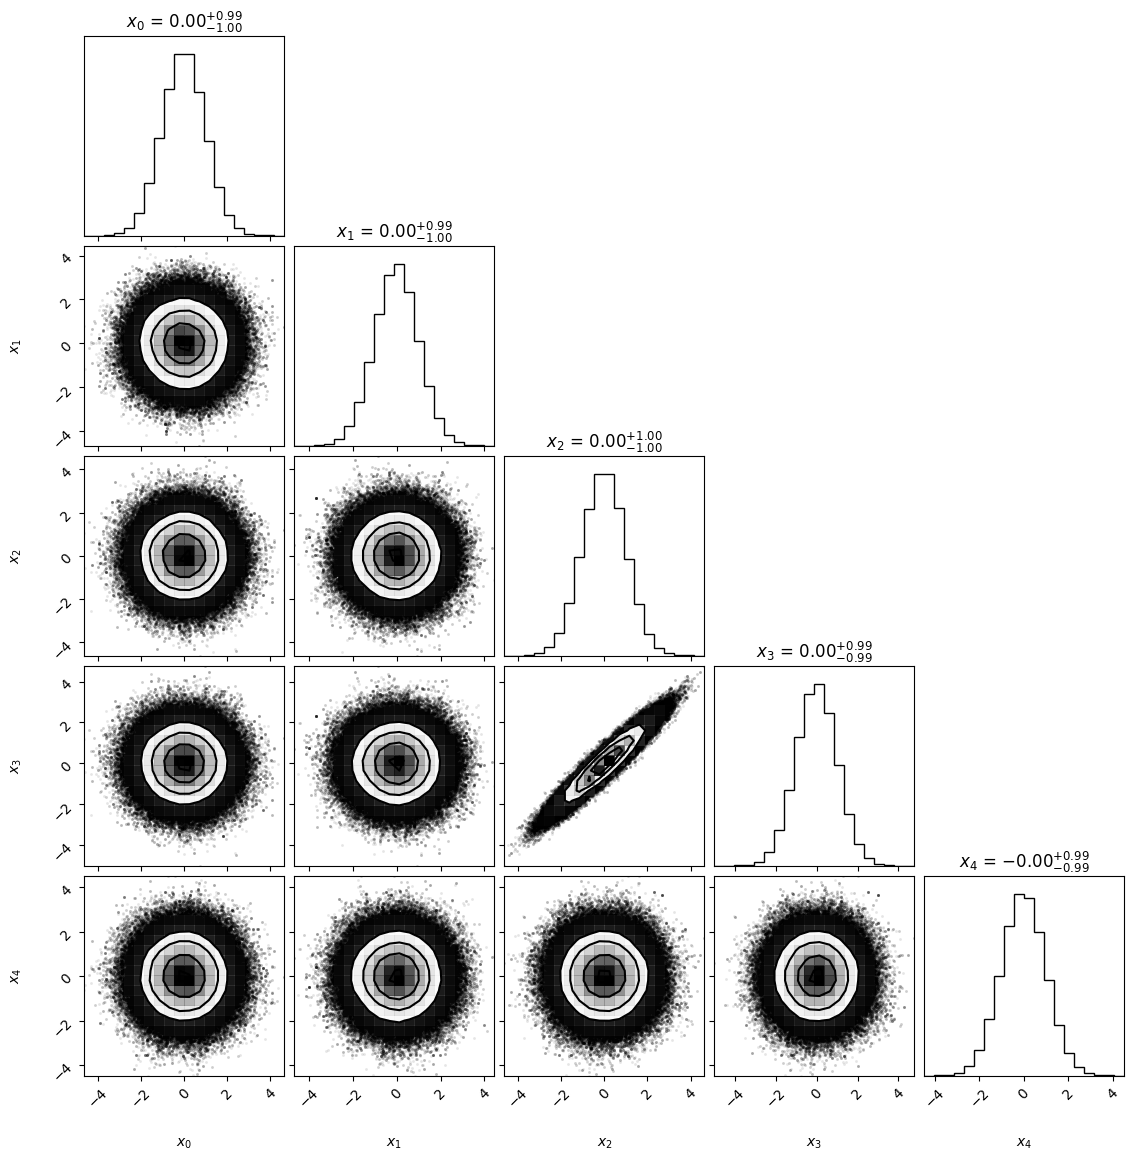

In [22]:
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
import os
import json

# Uniform prior
def log_prior(theta):
    if np.all((-10 < theta) & (theta < 10)):
        return 0.0
    return -np.inf

# Covariance matrix: correlated (x2, x3), uncorrelated rest
cov = np.eye(5)
cov[2, 3] = cov[3, 2] = 0.95
cov_inv = np.linalg.inv(cov)

def log_likelihood(theta):
    return -0.5 * np.dot(theta, cov_inv.dot(theta))

def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

# MCMC setup
ndim = 5
nwalkers = 100
p0 = np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

# Burn-in and sampling
nburn = 500
sampler.run_mcmc(p0, nburn, progress=True)
sampler.reset()
nsteps = 10000
sampler.run_mcmc(None, nsteps, progress=True)
samples = sampler.get_chain(flat=True)

# Save outputs
output_dir = "/Users/kahaan/Downloads/cmbagent/MCMC_cov5d"
os.makedirs(output_dir, exist_ok=True)
np.save(os.path.join(output_dir, "samples.npy"), samples)
with open(os.path.join(output_dir, "metadata.json"), 'w') as f:
    json.dump({"ndim": ndim, "covariance": cov.tolist()}, f)

# Corner plots
labels = [f"$x_{i}$" for i in range(ndim)]
figure = corner.corner(
    samples,
    labels=labels,
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
)
figure.savefig(os.path.join(output_dir, "cov5d_corner.png"), dpi=150)
plt.show()

In [1]:
import base64
import json
from PIL import Image
from google import genai
from cmbagent.utils import get_api_keys_from_env
from autogen.agentchat.group import ContextVariables

api_keys = get_api_keys_from_env()
client = genai.Client(api_key=api_keys["GEMINI"])

def load_plot_as_base64(image_path):
    """Load an image and convert to base64 for VLM analysis"""
    with open(image_path, 'rb') as f:
        image_data = f.read()
        return base64.b64encode(image_data).decode('utf-8')

# Get corner plot path
corner_plot_path = "/Users/kahaan/Downloads/cmbagent/MCMC_cov5d/cov5d_corner.png"
plot_base64 = load_plot_as_base64(corner_plot_path)

In [27]:
# APPROACH 1: default API call

question = "This is a corner plot of an MCMC posterior. Evaluate which pair(s) of parameters show high covariance."

answer = client.models.generate_content(
    model="gemini-2.5-pro",
    contents=[
        {
            'role': 'user',
            'parts': [
                {'inline_data': {'mime_type': 'image/png', 'data': plot_base64}},
                {'text': question}
            ]
        }
    ]
)

print(answer.text)

Based on the provided corner plot, the pair of parameters that shows high covariance is **(x₂, x₃)**.

Here's how to interpret the plot to reach this conclusion:

*   **No Covariance:** In a corner plot, when two parameters are uncorrelated (have zero or very low covariance), their joint distribution plot (the 2D scatter/contour plots) appears circular. This indicates that the value of one parameter does not depend on the value of the other. Most of the pairs in this plot, such as (x₁, x₀) or (x₄, x₁), show this circular pattern.

*   **High Covariance:** When two parameters are highly correlated (have high covariance), their joint distribution plot is elongated into an ellipse.
    *   The plot for **(x₂, x₃)**, located in the fourth row and third column, clearly shows this elliptical shape. The points are concentrated along a narrow diagonal line slanting from the bottom-left to the top-right.
    *   This specific orientation indicates a **strong positive covariance**: as the value 

In [30]:
# APPROACH 2: vision-based analysis with plot judge

from cmbagent.vlm_utils import send_image_to_vlm, create_vlm_prompt

# Create context variables for the VLM system
context_variables = ContextVariables()
context_variables["improved_main_task"] = "Evaluate which pair(s) of parameters show the highest covariance."

# Plot judge relies on function, not AG2 agent
completion, injected_code = send_image_to_vlm(
    base_64_img=plot_base64,
    vlm_prompt=create_vlm_prompt(context_variables),
    inject_wrong_plot=False,
    context_variables=context_variables
)

# Parse the structured response
analysis = json.loads(completion.choices[0].message.content)
print(analysis)

VLM scientific accuracy description:
Assessment of scientific accuracy: Are the data points, calculations, and scientific principles accurate? Are the units, scales, and relationships correct? Are there any mathematical or scientific errors?

ADDITIONAL DOMAIN-SPECIFIC CRITERIA:
"Feature name: Covariance Ellipse Orientation in Covariance Matrix Plot

- Expected orientation: Ellipse with semi-major axis aligned with the line y = x
  - If rotated significantly from y = x: indicates non-linear relationships or errors in scaling (invalid for linear covariance)
  
- Expected ratio of axes: Length of semi-major axis should be significantly greater than semi-minor axis
  - If axes are nearly equal: indicates low covariance or similar variance in both variables (invalid for high covariance detection)
  
- Expected aspect ratio: High aspect ratio with semi-major axis significantly larger
  - If aspect ratio is low: indicates poor linear correlation between parameters (invalid for cases of stron

In [5]:
# APPROACH 3: text-based analysis with cmbagent

import numpy as np

# Save a simple data description file for cmbagent to find
data_info_content = f"""
# MCMC Posterior Samples Data

This directory contains MCMC posterior samples.

Files:
- samples.npy: Flattened MCMC samples (shape: {len(np.load('/Users/kahaan/Downloads/cmbagent/MCMC_cov5d/samples.npy'))}, 2)
- chain.npy: Full MCMC chain data  
- log_prob.npy: Log probability values
- metadata.json: Run parameters and statistics

Task: Analyze this data to determine the shape of the distribution and assess bimodality.
"""

# Save data info file
with open("/Users/kahaan/Downloads/cmbagent/MCMC_cov5d/README.md", 'w') as f:
    f.write(data_info_content)

# Create task for cmbagent - give it the data path and let it analyze
task = f"""
You have been provided with MCMC posterior sample data in the directory /Users/kahaan/Downloads/cmbagent/MCMC_cov5d/

Load and analyze the samples.npy file (and other data files as needed).
Evaluate which pair(s) of parameters show the highest covariance.

Give a clear conclusion based on the data.
"""
import cmbagent
import tempfile

with tempfile.TemporaryDirectory() as temp_work_dir:    
    results = cmbagent.one_shot(
        task=task,
        max_rounds=10,
        agent='engineer',
        work_dir=temp_work_dir,
        evaluate_plots=False,
    )


You have been provided with MCMC posterior sample data in the directory /Users/kahaan/Downloads/cmbagent/MCMC_cov5d/

Load and analyze the samples.npy file (and other data files as needed).
Evaluate which pair(s) of parameters show the highest covariance.

Give a clear conclusion based on the data.


--------------------------------------------------------------------------------

Calling engineer...

             Model    agent    Cost  Prompt Tokens  Completion Tokens  Total Tokens
gpt-4.1-2025-04-14 engineer 0.01370           1706               1286          2992
**Code Explanation:**

This code loads the MCMC posterior samples from the provided `samples.npy` file, computes the covariance matrix for the parameters, and identifies the pair(s) of parameters with the highest absolute covariance. It also visualizes the covariance matrix as a heatmap, saving the plot in the `data/` directory. The code prints a detailed summary of the covariance matrix and clearly states which parameter 

### MCMC w/ ring-shaped posterior

$$
\log p(x, y) = -\frac{1}{2} \left( \sqrt{x^2 + y^2} - r_0 \right)^2
$$

Basic VLM: "this posterior distribution is not consistent with a Gaussian likelihood"  
Plot judge: "is not consistent with a Gaussian likelihood"  
cmbagent: "at least one marginal distribution is NOT consistent with a Gaussian likelihood"  

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:05<00:00, 1848.99it/s]


Saved 1000000 samples to /Users/kahaan/Downloads/cmbagent/MCMC_donut


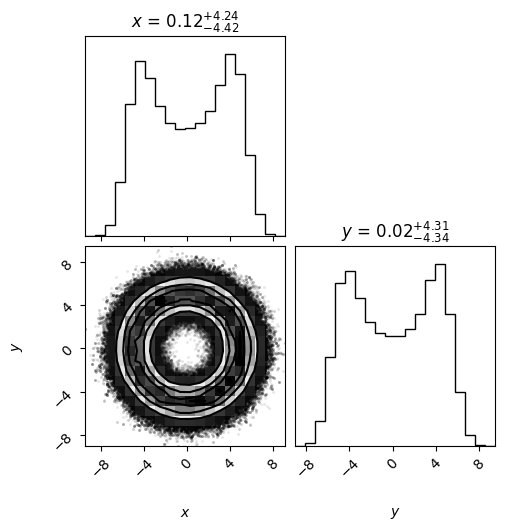

In [9]:
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
import os
import json

# Uniform prior
def log_prior(theta):
    x, y = theta
    if -20 < x < 20 and -20 < y < 20:
        return 0.0
    return -np.inf

# Donut-shaped likelihood
r0 = 5.0

def log_likelihood(theta):
    x, y = theta
    r = np.sqrt(x**2 + y**2)
    return -0.5 * (r - r0)**2  # peak when r ≈ r0

# Posterior
def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

# MCMC setup
ndim = 2
nwalkers = 100
p0 = np.random.randn(nwalkers, ndim)
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

# Burn-in and sampling
nburn = 500
sampler.run_mcmc(p0, nburn, progress=True)
sampler.reset()
nsteps = 10000
sampler.run_mcmc(None, nsteps, progress=True)
samples = sampler.get_chain(flat=True)

# Save outputs
output_dir = "/Users/kahaan/Downloads/cmbagent/MCMC_donut"
os.makedirs(output_dir, exist_ok=True)
np.save(os.path.join(output_dir, "samples.npy"), samples)

metadata = {
    "r0": r0,
    "nwalkers": 100,
    "nsteps": nsteps,
    "ndim": ndim,
    "nburn": nburn
}
with open(os.path.join(output_dir, "metadata.json"), "w") as f:
    json.dump(metadata, f)

print(f"Saved {len(samples)} samples to {output_dir}")

# Corner plot
figure = corner.corner(
    samples,
    labels=["$x$", "$y$"],
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
)
figure.savefig(os.path.join(output_dir, "donut_corner_plot.png"), dpi=150)
plt.show()

In [10]:
import base64
import json
from PIL import Image
from google import genai
from cmbagent.utils import get_api_keys_from_env
from autogen.agentchat.group import ContextVariables

api_keys = get_api_keys_from_env()
client = genai.Client(api_key=api_keys["GEMINI"])

def load_plot_as_base64(image_path):
    """Load an image and convert to base64 for VLM analysis"""
    with open(image_path, 'rb') as f:
        image_data = f.read()
        return base64.b64encode(image_data).decode('utf-8')

# Get corner plot path
corner_plot_path = "/Users/kahaan/Downloads/cmbagent/MCMC_donut/donut_corner_plot.png"
plot_base64 = load_plot_as_base64(corner_plot_path)

In [12]:
# APPROACH 1: default API call

question = "This is a corner plot of an MCMC posterior. Evaluate whether this is plot consistent with a Gaussian likelihood?"

answer = client.models.generate_content(
    model="gemini-2.5-pro",
    contents=[
        {
            'role': 'user',
            'parts': [
                {'inline_data': {'mime_type': 'image/png', 'data': plot_base64}},
                {'text': question}
            ]
        }
    ]
)

print(answer.text)

Based on the visual evidence in the corner plot, this posterior distribution is **not consistent with a Gaussian likelihood**.

Here is the reasoning:

1.  **Marginal Distributions (Histograms):**
    *   A Gaussian distribution is unimodal (has a single peak) and is bell-shaped.
    *   The histograms for both `x` (top plot) and `y` (right plot) are clearly **bimodal**, with two distinct peaks and a significant dip in the center around zero. This is a strong deviation from a Gaussian shape.

2.  **Joint Distribution (2D Plot):**
    *   A two-dimensional Gaussian distribution has elliptical (or circular) contours, with the highest probability density at the center (the mean) and decreasing density as you move away from the center.
    *   The 2D plot in the bottom left corner shows an **annular or ring-like distribution**. The probability density is low in the center, increases to a maximum in a ring, and then decreases again further out. This is fundamentally different from the centr

In [13]:
# APPROACH 2: vision-based analysis with plot judge

from cmbagent.vlm_utils import send_image_to_vlm, create_vlm_prompt

# Create context variables for the VLM system
context_variables = ContextVariables()
context_variables["improved_main_task"] = "Evaluate whether this is plot consistent with a Gaussian likelihood?"

# Plot judge relies on function, not AG2 agent
completion, injected_code = send_image_to_vlm(
    base_64_img=plot_base64,
    vlm_prompt=create_vlm_prompt(context_variables),
    inject_wrong_plot=False,
    context_variables=context_variables
)

# Parse the structured response
analysis = json.loads(completion.choices[0].message.content)
print(analysis)

VLM scientific accuracy description:
Assessment of scientific accuracy: Are the data points, calculations, and scientific principles accurate? Are the units, scales, and relationships correct? Are there any mathematical or scientific errors?

ADDITIONAL DOMAIN-SPECIFIC CRITERIA:
Check the following features for consistency with a Gaussian likelihood plot:

1. **Symmetry about the mean (μ)**:
   - The plot should be symmetric around the mean value on the x-axis.
   - If skewed to the left (x < μ): indicates data skewness or outliers (invalid as Gaussian distribution assumes symmetry).
   - If skewed to the right (x > μ): indicates data skewness or outliers (invalid as Gaussian distribution assumes symmetry).
   - Symmetry is expected due to the central limit theorem in random processes.

2. **Mean value alignment (μ)**:
   - The peak of the distribution should align with the mean value on the x-axis.
   - If peaked at x < μ: indicates systematic bias or incorrect mean calculation (inval

In [11]:
# APPROACH 3: text-based analysis with cmbagent

import numpy as np

# Save a simple data description file for cmbagent to find
data_info_content = f"""
# MCMC Posterior Samples Data

This directory contains MCMC posterior samples.

Files:
- samples.npy: Flattened MCMC samples (shape: {len(np.load('/Users/kahaan/Downloads/cmbagent/MCMC_donut/samples.npy'))}, 2)
- chain.npy: Full MCMC chain data  
- log_prob.npy: Log probability values
- metadata.json: Run parameters and statistics

Task: Analyze this data to determine the shape of the distribution and assess bimodality.
"""

# Save data info file
with open("/Users/kahaan/Downloads/cmbagent/MCMC_donut/README.md", 'w') as f:
    f.write(data_info_content)

# Create task for cmbagent - give it the data path and let it analyze
task = f"""
You have been provided with MCMC posterior sample data in the directory /Users/kahaan/Downloads/cmbagent/MCMC_donut/

Load and analyze the samples.npy file (and other data files as needed).
Evaluate whether this is plot consistent with a Gaussian likelihood?

Give a clear conclusion based on the data.
"""
import cmbagent
import tempfile

with tempfile.TemporaryDirectory() as temp_work_dir:    
    results = cmbagent.one_shot(
        task=task,
        max_rounds=10,
        agent='engineer',
        work_dir=temp_work_dir,
        evaluate_plots=False,
    )


You have been provided with MCMC posterior sample data in the directory /Users/kahaan/Downloads/cmbagent/MCMC_donut/

Load and analyze the samples.npy file (and other data files as needed).
Evaluate whether this is plot consistent with a Gaussian likelihood?

Give a clear conclusion based on the data.


--------------------------------------------------------------------------------

Calling engineer...

             Model    agent    Cost  Prompt Tokens  Completion Tokens  Total Tokens
gpt-4.1-2025-04-14 engineer 0.01717           1702               1721          3423
**Code Explanation:**

This code loads the MCMC posterior samples from `samples.npy` in the provided directory, analyzes their marginal and joint distributions, and compares them to what would be expected from a Gaussian likelihood. It does this by:
- Loading the samples and printing their shape and summary statistics.
- Plotting 1D histograms and 2D scatter plots (corner plot) for the parameters, overlaying a multivari

### $N_{\text{experiment}}$ Contour Generation

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:01<00:00, 3806.92it/s]


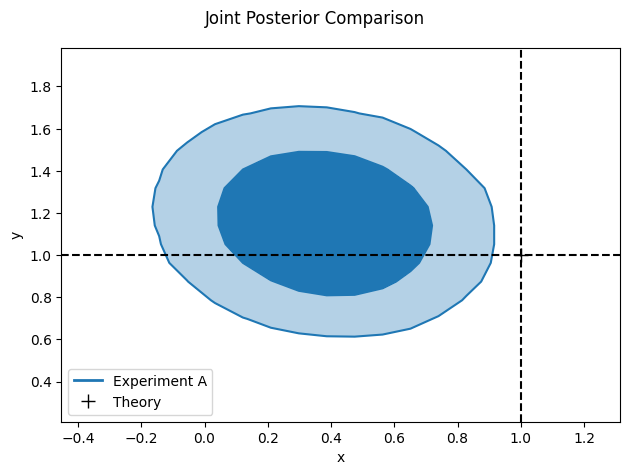

In [17]:
import os
import numpy as np
import emcee
import corner
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

# Output directory
OUTPUT_DIR = "/Users/kahaan/Downloads/cmbagent/MCMC_contours"
os.makedirs(OUTPUT_DIR, exist_ok=True)


def log_prob(theta, mean, cov_inv):
    """Log-probability for a Gaussian posterior."""
    diff = theta - mean
    return -0.5 * diff @ cov_inv @ diff


def generate_chain(mean, cov, nwalkers=50, nsteps=5000, burn=200):
    """Run emcee to sample from a multivariate normal."""
    ndim = len(mean)
    cov_inv = np.linalg.inv(cov)
    # Initialize walkers near the mean
    p0 = mean + 1e-4 * np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(mean, cov_inv))
    sampler.run_mcmc(p0, nsteps, progress=True)
    # Return flattened chain after burn-in
    return sampler.get_chain(discard=burn, flat=True)


def simulate_experiments(n_experiments=1, sigma=0.2):
    """Generate chains whose 2σ contour excludes the theory point (1,1)."""
    labels = list("ABCDEFGHIJKLMNOPQRSTUVWXYZ")
    theory = np.array([1.0, 1.0])
    cov = np.eye(2) * sigma**2
    cov[0,1] = np.random.uniform(-1, 1) * sigma**2
    cov[1,0] = np.random.uniform(-1, 1) * sigma**2
    cov_inv = np.linalg.inv(cov)
    exp_data = {}
    for i in range(n_experiments):
        # Pick a mean >2σ away
        while True:
            mean = theory + np.random.randn(2) * (2.5 * sigma)
            dist = np.sqrt((mean - theory) @ cov_inv @ (mean - theory))
            if dist > 2:
                break
        exp_data[labels[i]] = generate_chain(mean, cov)
    return theory, exp_data


def save_chains(exp_data):
    """Save each chain as a .npy file."""
    for label, samples in exp_data.items():
        path = os.path.join(OUTPUT_DIR, f"experiment_{label}_samples.npy")
        np.save(path, samples)
        print(f"Saved chain to {path}")


def plot_joint(exp_data, theory):
    """Plot 2D joint posterior contours and save the figure."""
    # Combine all samples for range
    all_samples = np.vstack(list(exp_data.values()))
    x_min, x_max = all_samples[:,0].min(), all_samples[:,0].max()
    y_min, y_max = all_samples[:,1].min(), all_samples[:,1].max()

    fig, ax = plt.subplots()
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    handles, labels = [], []

    for idx, (label, samples) in enumerate(exp_data.items()):
        color = colors[idx]
        corner.hist2d(
            samples[:,0], samples[:,1],
            levels=[0.68, 0.95],
            plot_datapoints=False,
            fill_contours=True,
            smooth=1.0,
            color=color,
            ax=ax
        )
        handles.append(Line2D([], [], color=color, lw=2))
        labels.append(f"Experiment {label}")

    # Theory crosshair
    ax.axvline(theory[0], ls='--', color='k')
    ax.axhline(theory[1], ls='--', color='k')
    ax.plot(theory[0], theory[1], marker='+', ms=10, color='k')
    handles.append(Line2D([], [], color='k', marker='+', linestyle='None', markersize=10))
    labels.append("Theory")

    # Formatting
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.legend(handles, labels, loc='lower left')
    fig.suptitle('Joint Posterior Comparison')
    fig.tight_layout()

    # Save figure
    # fig_file = os.path.join(OUTPUT_DIR, 'joint_posterior_comparison.png')
    # fig.savefig(fig_file)
    # print(f"Saved plot to {fig_file}")
    return fig


n_experiments = 1
theory, exp_data = simulate_experiments(n_experiments=n_experiments)
# save_chains(exp_data)
fig = plot_joint(exp_data, theory)
plt.show()

In [1]:
import base64
import json
from PIL import Image
from google import genai
from cmbagent.utils import get_api_keys_from_env
from autogen.agentchat.group import ContextVariables

api_keys = get_api_keys_from_env()
client = genai.Client(api_key=api_keys["GEMINI"])

def load_plot_as_base64(image_path):
    """Load an image and convert to base64 for VLM analysis"""
    with open(image_path, 'rb') as f:
        image_data = f.read()
        return base64.b64encode(image_data).decode('utf-8')

# Get corner plot path
corner_plot_path = "/Users/kahaan/Downloads/cmbagent/MCMC_contours/joint_posterior_comparison.png"
plot_base64 = load_plot_as_base64(corner_plot_path)

In [32]:
# APPROACH 1: default API call

question = "This plot shows the MCMC posterior distributions alongside the theoretical predictions. Please assess whether the theory agrees with the experimental data."

answer = client.models.generate_content(
    model="gemini-2.5-pro",
    contents=[
        {
            'role': 'user',
            'parts': [
                {'inline_data': {'mime_type': 'image/png', 'data': plot_base64}},
                {'text': question}
            ]
        }
    ]
)

print(answer.text)

Based on the provided plot, the theory does **not** agree with the experimental data from either Experiment A or Experiment B.

Here's a breakdown of the assessment:

1.  **What the Plot Shows:**
    *   **Experimental Data (Contours):** The colored regions for "Experiment A" (blue) and "Experiment B" (orange) represent the joint posterior distributions for the parameters 'x' and 'y'. These are essentially "maps" of the most probable values for these parameters, given the data from each experiment. The inner, darker regions represent higher confidence (e.g., 68% credibility region or 1-sigma), and the outer, lighter regions represent a lower, but still high, confidence (e.g., 95% credibility region or 2-sigma).
    *   **Theory (Black Cross):** The black crosshair marker indicates the specific values for 'x' and 'y' predicted by the theory. From the dashed lines, we can see the theoretical prediction is at the point **(x=1.0, y=1.0)**.

2.  **The Comparison:**
    *   For a theory to b

In [3]:
# APPROACH 2: vision-based analysis with plot judge

from google import genai
from cmbagent.utils import get_api_keys_from_env
from autogen.agentchat.group import ContextVariables
from cmbagent.vlm_utils import send_image_to_vlm, create_vlm_prompt

api_keys = get_api_keys_from_env()
client = genai.Client(api_key=api_keys["GEMINI"])

# Create context variables for the VLM system
context_variables = ContextVariables()
context_variables["improved_main_task"] = "This plot shows the MCMC posterior distributions alongside the predicted theoretical value. Please assess whether the theory agrees with the experimental data."

# Plot judge relies on function, not AG2 agent
completion, injected_code = send_image_to_vlm(
    base_64_img=plot_base64,
    vlm_prompt=create_vlm_prompt(context_variables),
    inject_wrong_plot=False,
    context_variables=context_variables
)

# Parse the structured response
analysis = json.loads(completion.choices[0].message.content)
print(analysis)

VLM scientific accuracy description:
Assessment of scientific accuracy: Are the data points, calculations, and scientific principles accurate? Are the units, scales, and relationships correct? Are there any mathematical or scientific errors?

ADDITIONAL DOMAIN-SPECIFIC CRITERIA:
Feature: Posterior Distribution Peaks
- Expected at x ≈ [theoretical parameter value], y ≈ [maximum probability value]
  - If shifted to x < [theoretical parameter value]: indicates model underfitting or systematic bias (invalid because it suggests the model does not adequately capture the data)
  - If shifted to x > [theoretical parameter value]: indicates model overfitting or systematic bias (invalid because it suggests the model is overly complex or data has a systematic error)
  - If peak is significantly lower than maximum probability: indicates high uncertainty in the parameter estimation (invalid if known system should have greater certainty)

Feature: Credible Interval (e.g., 95% CI)
- Expected to encom

In [37]:
os.listdir("/Users/kahaan/Downloads/cmbagent/MCMC_contours/")

['experiment_C_samples.npy',
 'joint_posterior_comparison.png',
 'experiment_B_samples.npy',
 'experiment_A_samples.npy',
 'experiment_D_samples.npy']

In [41]:
# APPROACH 3: text-based analysis with cmbagent

task = f"""
You have been provided with MCMC posterior sample data in the directory /Users/kahaan/Downloads/cmbagent/MCMC_contours/

For each experiments (A and B), you have a file experiment_B_samples.npy, holding a chain of shape (240000, 2).

Theory predicts that both paramter values are 1. Assess whether or not the theory agrees with the experimental data, and return a single Yes/No answer."
"""
import cmbagent
import numpy as np

results = cmbagent.one_shot(
    task=task,
    agent='engineer',
    evaluate_plots=False,
    clear_work_dir=True,
)


You have been provided with MCMC posterior sample data in the directory /Users/kahaan/Downloads/cmbagent/MCMC_contours/

For each experiments in A-D, you have a file experiment_B_samples.npy, holding a chain of shape (240000, 2).

Theory predicts that both paramter values are 1. Assess whether or not the theory agrees with the experimental data, and return a single Yes/No answer."


--------------------------------------------------------------------------------

Calling engineer...

             Model    agent    Cost  Prompt Tokens  Completion Tokens  Total Tokens
gpt-4.1-2025-04-14 engineer 0.00855           1752                631          2383
**Code Explanation:**

The code loads the MCMC posterior samples for experiment B, computes the 95% credible intervals for both parameters, and checks if the theoretical value (1, 1) lies within these intervals. It prints the credible intervals, the mean and standard deviation for each parameter, and finally prints "Yes" if the theory is co

### DESI-like discrepancy: 2 plots

* Define our model as $y(x; a,b) \;=\; c \;+\; a\,x^2 \;+\; b\,x^3$.  
* Define theory parameters $(a_{\rm th},b_{\rm th}) = (0.5, 1)$, fix $c = 1$, and sample with uniform noise $\sigma_y=0.1$.
* Simulate two datasets: A, where all points are within 1σ of theory, and B, with a single one 5σ outlier; 7 equally spaced points on $[-2,2]$
    * Note that outlier encourages non-zero cubic contribution, diverging from theory
* Fit models to each dataset w/ MCMC with flat priors and Gaussian log-likelihood (50 walkers, 2000 steps, 500 burn-in)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1747.43it/s]


Saved chain_A to /Users/kahaan/Downloads/cmbagent/MCMC_2_plots/chain_A.npy


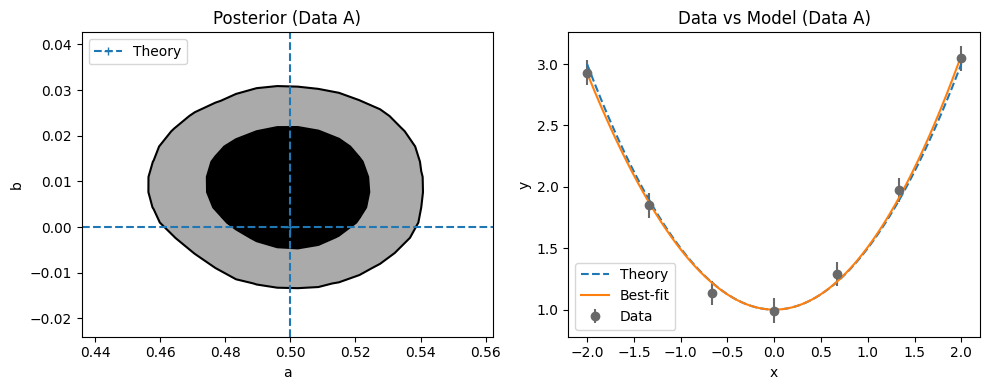

Saved combined_A to /Users/kahaan/Downloads/cmbagent/MCMC_2_plots/combined_A.png


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [00:01<00:00, 1755.71it/s]


Saved chain_B to /Users/kahaan/Downloads/cmbagent/MCMC_2_plots/chain_B.npy


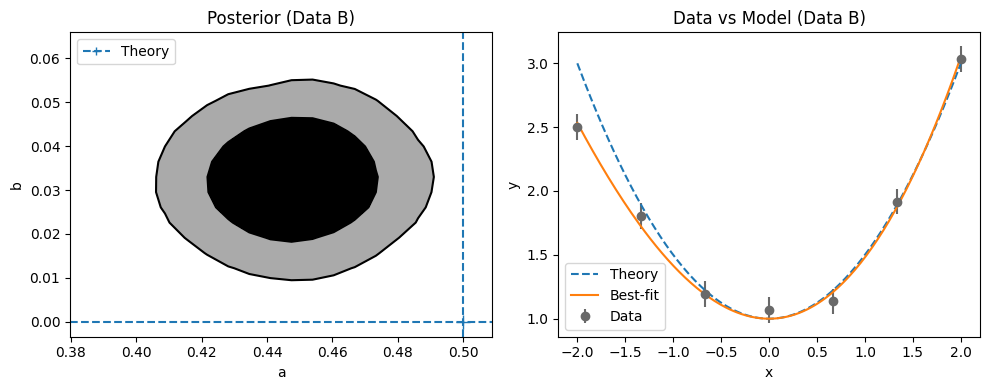

Saved combined_B to /Users/kahaan/Downloads/cmbagent/MCMC_2_plots/combined_B.png


In [48]:
import os
import numpy as np
import emcee
import corner
import shutil
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

np.random.seed(777)

# Clean slate on each run
OUTPUT_DIR = "/Users/kahaan/Downloads/cmbagent/MCMC_2_plots"
if os.path.exists(OUTPUT_DIR):
    shutil.rmtree(OUTPUT_DIR)
os.makedirs(OUTPUT_DIR)

# Standard-model parameters
a_theory = 0.5  # Quadratic coefficient
b_theory = 0.0  # Cubic coefficent
c_theory = 1.0  # Constant shift

# Noise level for generated data
sigma_y = 0.1

# Number of data measurements
x_vals = np.linspace(-2, 2, 7)


def model(x, a, b):
    return c_theory + a * x**2 + b * x**3


def log_likelihood(theta, x, y, yerr):
    """
    Gaussian log-likelihood: P(θ | data), where θ = [a,b] are model parameters and data = [x,y] are the measurements.
    """
    a, b = theta
    y_model = model(x, a, b)
    return -0.5 * np.sum(((y - y_model) / yerr)**2 + np.log(2 * np.pi * yerr**2))


def log_prior(theta):
    """
    Flat priors: a in [0, 1] and b in [-1, 1].
    """
    a, b = theta
    if 0.0 < a < 1.0 and -1.0 < b < 1.0:
        return 0.0
    return -np.inf


def log_prob(theta, x, y, yerr):
    """
    Combined log-probability: P(θ | data) = P(θ) * P(data | θ).
    """
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, x, y, yerr)


def run_mcmc(x, y, yerr, nwalkers=50, nsteps=2000, burn=500):
    """
    Call emcee sampler and return flatterened chain.
    """
    ndim = 2
    # Initialize walkers in a tight ball around theory
    p0 = np.array([a_theory, b_theory]) + 1e-3 * np.random.randn(nwalkers, ndim)
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, args=(x, y, yerr))
    sampler.run_mcmc(p0, nsteps, progress=True)
    return sampler.get_chain(discard=burn, flat=True)


def simulate_data(introduce_outlier=False):
    """
    Generate two datasets: good (all within ±1σ) or with one 5σ outlier.
    """
    # Base y from theory + uniform noise within ±1σ
    y_clean = model(x_vals, a_theory, b_theory)
    noise = np.random.uniform(-sigma_y, sigma_y, size=x_vals.size)
    y = y_clean + noise
    
    # Introduce one 5σ outlier at leftmost x, encouraging non-zero cubic coefficient
    if introduce_outlier:
        y[0] = y_clean[0] - 5 * sigma_y
    return y


def save_chain(chain, label):
    fname = os.path.join(OUTPUT_DIR, f"chain_{label}.npy")
    np.save(fname, chain)
    print(f"Saved chain_{label} to {fname}")


def plot_combined(chain, x, y, label):
    tab_colors   = plt.rcParams['axes.prop_cycle'].by_key()['color']
    theory_color = tab_colors[0]
    data_color   = "dimgray"
    fit_color    = tab_colors[1]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))

    # Left: joint posterior
    corner.hist2d(
        chain[:, 0], chain[:, 1],
        levels=[0.68, 0.95],
        plot_datapoints=False,
        fill_contours=True,
        smooth=1.0,
        ax=ax1
    )
    
    ax1.axvline(a_theory, ls='--', color=theory_color)
    ax1.axhline(b_theory, ls='--', color=theory_color)
    ax1.plot(a_theory, b_theory, marker='+', ms=10, color=theory_color)
    legend_handle = Line2D([], [], color=theory_color, linestyle='--', marker='+', label='Theory')
    ax1.legend(handles=[legend_handle], loc='upper left')
    ax1.set_xlabel('a')
    ax1.set_ylabel('b')
    ax1.set_title(f'Posterior (Data {label})')

    # Right: data vs model
    yerr = np.full_like(y, sigma_y)
    a_med, b_med = np.median(chain, axis=0)
    ax2.errorbar(x, y, yerr=yerr, fmt='o', color=data_color, label='Data')
    xs = np.linspace(x.min(), x.max(), 200)
    ax2.plot(xs, model(xs, a_theory, b_theory), '--', label='Theory', color=theory_color)
    ax2.plot(xs, model(xs, a_med, b_med), '-', label='Best-fit', color=fit_color)
    ax2.set_xlabel('x')
    ax2.set_ylabel('y')
    ax2.set_title(f'Data vs Model (Data {label})')
    ax2.legend()

    fig.tight_layout()
    fname = os.path.join(OUTPUT_DIR, f"combined_{label}.png")
    fig.savefig(fname)
    plt.show()
    print(f"Saved combined_{label} to {fname}")
    plt.close(fig)


if __name__ == '__main__':
    for label in ['A', 'B']:
        y = simulate_data(label=='B')
        chain = run_mcmc(x_vals, y, np.full_like(y, sigma_y))
        save_chain(chain, label)
        plot_combined(chain, x_vals, y, label)

In [49]:
import base64
import json
from PIL import Image
from google import genai
from cmbagent.utils import get_api_keys_from_env
from autogen.agentchat.group import ContextVariables

api_keys = get_api_keys_from_env()
client = genai.Client(api_key=api_keys["GEMINI"])

def load_plot_as_base64(image_path):
    """Load an image and convert to base64 for VLM analysis"""
    with open(image_path, 'rb') as f:
        image_data = f.read()
        return base64.b64encode(image_data).decode('utf-8')

# Get corner plot path
corner_plot_path = "/Users/kahaan/Downloads/cmbagent/MCMC_2_plots/combined_B.png"
plot_base64 = load_plot_as_base64(corner_plot_path)

In [57]:
# APPROACH 1: default API call

question = """
This plot includes the joint posterior distribution for (a, b) with the theory prediction overlaid as a crosshair,
and the experimental data vs. x, with both the theoretical curve and MCMC best-fit curve shown.

Why does the theory disagree or agree with the data? Be specific.
"""

answer = client.models.generate_content(
    model="gemini-2.5-pro",
    contents=[
        {
            'role': 'user',
            'parts': [
                {'inline_data': {'mime_type': 'image/png', 'data': plot_base64}},
                {'text': question}
            ]
        }
    ]
)

print(answer.text)

Based on the provided plots, the **theory disagrees with the data**.

Here is a specific breakdown of why, using evidence from both plots:

### 1. Evidence from the Posterior Plot (Left)

*   **What it shows:** This plot displays the joint posterior probability distribution for the model parameters `a` and `b`. The shaded regions (representing confidence levels, e.g., 68% and 95%) show the values of `a` and `b` that are most consistent with the experimental data.
*   **The Theory's Prediction:** The theory predicts specific values for the parameters, which are shown by the blue dashed crosshair at **`a = 0.50`** and **`b = 0.00`**.
*   **The Disagreement:** This theoretical point `(a=0.50, b=0.00)` lies far outside the high-probability regions inferred from the data. The data strongly favor values centered around `a ≈ 0.44` and `b ≈ 0.035`. The theory's prediction is statistically excluded by the experimental results.

### 2. Evidence from the Data vs. Model Plot (Right)

*   **What it

In [58]:
# APPROACH 2: vision-based analysis with plot judge

from google import genai
from cmbagent.utils import get_api_keys_from_env
from autogen.agentchat.group import ContextVariables
from cmbagent.vlm_utils import send_image_to_vlm, create_vlm_prompt

api_keys = get_api_keys_from_env()
client = genai.Client(api_key=api_keys["GEMINI"])

# Create context variables for the VLM system
context_variables = ContextVariables()
context_variables["improved_main_task"] = """
Generate a plot including the joint posterior distribution for (a, b) with the theory prediction overlaid as a crosshair,
and the experimental data vs. x, with both the theoretical curve and MCMC best-fit curve shown.

Importantly for scientific accuracy, you must identify why the theory disagrees or agrees with the data. Be specific.

"""

# Plot judge relies on function, not AG2 agent
completion, injected_code = send_image_to_vlm(
    base_64_img=plot_base64,
    vlm_prompt=create_vlm_prompt(context_variables),
    inject_wrong_plot=False,
    context_variables=context_variables
)

# Parse the structured response
analysis = json.loads(completion.choices[0].message.content)
print(analysis)

VLM scientific accuracy description:
Assessment of scientific accuracy: Are the data points, calculations, and scientific principles accurate? Are the units, scales, and relationships correct? Are there any mathematical or scientific errors?

ADDITIONAL DOMAIN-SPECIFIC CRITERIA:
Joint Posterior Distribution with Theory Prediction:

Feature: Theory Prediction Overlay (Crosshair)
- Expected at specific known values of a and b (x ≈ a_theory, y ≈ b_theory)
  - If shifted to x < a_theory: indicates systematic bias in parameter 'a' (invalid if theory is robustly validated and applicable)
  - If shifted to x > a_theory: indicates discrepancies in model assumptions for 'a' (invalid if theoretical framework is robust)
  - If shifted to y < b_theory: implies systematic bias in parameter 'b' (invalid if experimental setup controls for known errors)
  - If shifted to y > b_theory: suggests incorrect modeling or oversight in parameter 'b' (invalid if model has been previously validated)

Feature: J

In [59]:
# APPROACH 3: text-based analysis with cmbagent

task = f"""
You have been provided with MCMC posterior sample data in the directory /Users/kahaan/Downloads/cmbagent/MCMC_2_plots/chain_B.npy, holding a chain of shape (75000, 2). 

Theory predicts that the first parameter (a) has a value of 0.5 and that the second parameter (b) has a value of 0. 

Your task is to identify why the theory disagrees or agrees with the data. Be specific.
"""
import cmbagent
import numpy as np

results = cmbagent.one_shot(
    task=task,
    agent='engineer',
    evaluate_plots=False,
)


You have been provided with MCMC posterior sample data in the directory /Users/kahaan/Downloads/cmbagent/MCMC_2_plots/chain_B.npy, holding a chain of shape (75000, 2). 

Theory predicts that the first parameter (a) has a value of 0.5 and that the second parameter (b) has a value of 0. 

Your task is to identify why the theory disagrees or agrees with the data. Be specific.



--------------------------------------------------------------------------------

Calling engineer...

             Model    agent    Cost  Prompt Tokens  Completion Tokens  Total Tokens
gpt-4.1-2025-04-14 engineer 0.01675           1774               1650          3424
**Code Explanation:**

This code loads the MCMC posterior samples from the provided `.npy` file, computes summary statistics (mean, standard deviation, 16th/84th percentiles) for both parameters, and compares them to the theoretical predictions (a=0.5, b=0). It then generates a corner plot (joint and marginal distributions) with the theoretical va